# Goldsmiths University of London
# MSc Data Science and Artificial Intelligence
# Final Project in Data Science (2023-24)
# Supervisor: Dr V L Raju Chinthalapati
# Author: Alperen Unal - aunal001
# Student ID: 33804283

## Phase 2: HAR Model

## 1. Utilising Modules

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

## 2. Data Preprocessing

In [7]:
prediction_df = pd.read_csv("prediction_scaled_log_returns.csv")
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31339 entries, 0 to 31338
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   spot_btc_coin_volume                  31339 non-null  float64
 1   futures_btc_close_price               31339 non-null  float64
 2   futures_btc_coin_volume               31339 non-null  float64
 3   futures_btc_coin_open_interest_close  31339 non-null  float64
 4   futures_btc_funding_rate              31339 non-null  float64
 5   futures_btc_CVD                       31339 non-null  float64
 6   futures_eth_close_price               31339 non-null  float64
 7   futures_eth_coin_open_interest_close  31339 non-null  float64
 8   futures_eth_funding_rate              31339 non-null  float64
 9   futures_eth_CVD                       31339 non-null  float64
 10  eth_etf                               31339 non-null  int64  
 11  btc_etf        

In [8]:
df = prediction_df[['futures_btc_close_price', 'futures_btc_coin_volume',
                    'futures_btc_coin_open_interest_close', 'futures_btc_funding_rate',
                    'futures_btc_CVD', 'log_returns', 'volatility']]

In [9]:

start_date = '2021-01-02 00:00:00'
end_date = '2024-07-30 18:00:00'
freq = 'H'  

datetime_index = pd.date_range(start=start_date, end=end_date, freq=freq)

df = df.set_index(datetime_index)

In [10]:
df

,futures_btc_close_price,futures_btc_coin_volume,futures_btc_coin_open_interest_close,futures_btc_funding_rate,futures_btc_CVD,log_returns,volatility
2021-01-02 00:00:00,29215.89,11380.580,36013.363,0.000100,-1.080364e+04,-0.004142,0.005182
2021-01-02 01:00:00,29380.00,7693.401,35530.754,0.000100,-1.072782e+04,0.005601,0.004329
2021-01-02 02:00:00,29347.02,6230.851,35781.508,0.000100,-1.051844e+04,-0.001123,0.004065
2021-01-02 03:00:00,29364.67,4118.911,35532.749,0.000100,-1.078220e+04,0.000601,0.004042
2021-01-02 04:00:00,29363.03,4267.183,35487.117,0.000100,-1.094671e+04,-0.000056,0.004012
...,...,...,...,...,...,...,...
2024-07-30 14:00:00,65779.40,23581.410,84405.692,0.000050,-1.856454e+06,-0.008747,0.004975
2024-07-30 15:00:00,66198.00,20218.770,83619.759,0.000077,-1.856047e+06,0.006344,0.005225
2024-07-30 16:00:00,66150.20,8097.586,83588.161,0.000092,-1.855806e+06,-0.000722,0.003993
2024-07-30 17:00:00,65839.80,15950.058,83142.319,0.000100,-1.856045e+06,-0.004703,0.004072


In [5]:
#To make a 10-day future forecast, the last 240 indices of the dataset were removed.

future_garch_df = df.iloc[:-240]
print(future_garch_df.shape)

(31099, 7)


The model variables were selected based on the feature engineering conducted in phase 1. For the HAR model, the model will be built using only the volatility variable and its lagged values due to the model's structure.

In [6]:
future_garch_df.loc[:, 'volatility_lag_240'] = future_garch_df['volatility'].shift(240)
future_garch_df.loc[:, 'volatility_lag_24'] = future_garch_df['volatility'].shift(24)
future_garch_df.loc[:, 'volatility_lag_168'] = future_garch_df['volatility'].shift(168)


/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_1368/3620679444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_garch_df.loc[:, 'volatility_lag_240'] = future_garch_df['volatility'].shift(240)
/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_1368/3620679444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_garch_df.loc[:, 'volatility_lag_24'] = future_garch_df['volatility'].shift(24)
/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_1368/3620679444.py:3: Set

In [7]:
future_garch_df.dropna(inplace=True)

/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_1368/2598294619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_garch_df.dropna(inplace=True)


## 3. Model Training and Testing

Fold 1 Train MSE: 0.000010
Fold 1 Test MSE: 0.000008
Fold 2 Train MSE: 0.000010
Fold 2 Test MSE: 0.000009
Fold 3 Train MSE: 0.000010
Fold 3 Test MSE: 0.000006
Fold 4 Train MSE: 0.000009
Fold 4 Test MSE: 0.000006
Fold 5 Train MSE: 0.000009
Fold 5 Test MSE: 0.000005
Fold 6 Train MSE: 0.000009
Fold 6 Test MSE: 0.000004
Fold 7 Train MSE: 0.000008
Fold 7 Test MSE: 0.000006
Fold 8 Train MSE: 0.000008
Fold 8 Test MSE: 0.000005

Genel Train MSE: 0.000009
Genel Test MSE: 0.000006


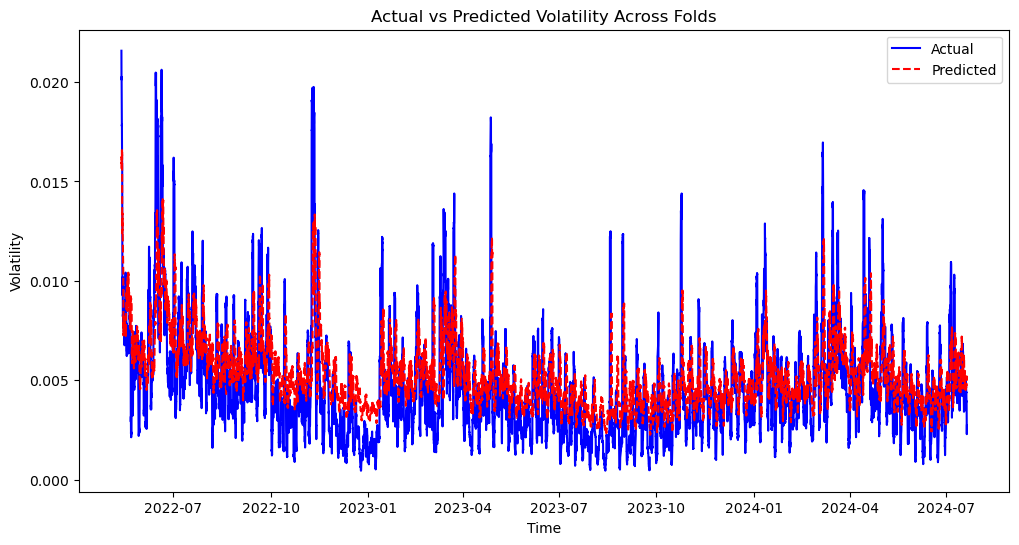

In [18]:
X = future_garch_df[[ 'volatility_lag_240', 'volatility_lag_24', 'volatility_lag_168']]
y = future_garch_df['volatility']

X = sm.add_constant(X)
X = X.dropna()
y = y[X.index]

# Utilising TimeSeriesSplit and the gap greater then the biggest lag value, to prevent data leakage
tss = TimeSeriesSplit(n_splits=8, test_size=24*100*1, gap=265)

train_mse_values = []
test_mse_values = []

# We create an empty DataFrame to save the prediction results
predictions_df = pd.DataFrame(columns=['Time', 'Actual', 'Predicted'])

plt.figure(figsize=(12, 6))

# Train and test the model for each fold
for i, (train_index, test_index) in enumerate(tss.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = sm.OLS(y_train, X_train).fit()
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)
    
    # Fold results
    print(f"Fold {i+1} Train MSE: {train_mse:.6f}")
    print(f"Fold {i+1} Test MSE: {test_mse:.6f}")
    
    # Adding the test set predictions to the DataFrame
    fold_predictions = pd.DataFrame({
        'Time': y_test.index,
        'Actual': y_test,
        'Predicted': y_test_pred
    })
    predictions_df = pd.concat([predictions_df, fold_predictions])
    
    plt.plot(y_test.index, y_test, label='Actual' if i == 0 else "", color='blue')
    plt.plot(y_test.index, y_test_pred, label='Predicted' if i == 0 else "", color='red', linestyle='--')

general_train_mse = np.mean(train_mse_values)
general_test_mse = np.mean(test_mse_values)

print(f"\nGenel Train MSE: {general_train_mse:.6f}")
print(f"Genel Test MSE: {general_test_mse:.6f}")

plt.title('Actual vs Predicted Volatility Across Folds')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# We save the prediction results in a CSV file to use as LSTM variables in the following phases.
predictions_df.to_csv('predicted__har_volatility.csv', index=False)

Actual and predicted values align well across multiple folds, and the consistently low Mean Squared Error (MSE) values indicate that the model accurately captures the underlying volatility patterns and generalizes well to unseen data. This consistency across folds underscores the model’s robustness and reliability, especially in stable market conditions.

## 4. Future Volatility Prediction

In [9]:
future_garch_df.index.max()

Timestamp('2024-07-20 18:00:00')

In [10]:
FEATURES = ['futures_btc_close_price', 'futures_btc_coin_volume',
       'futures_btc_coin_open_interest_close', 'futures_btc_funding_rate',
       'futures_btc_CVD', 'log_returns','volatility_lag_240', 'volatility_lag_24', 'volatility_lag_168']
TARGET = 'volatility'

X = future_garch_df[FEATURES]
y = future_garch_df[TARGET]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [11]:
# Generating time intervals for future prediction
future_dates = pd.date_range(start='2024-07-20 19:00:00', end='2024-07-30 19:00:00', freq='1H')

# Creating future DataFrame
future_df = pd.DataFrame(index=future_dates)

# Adding all the necessary features with NaN values
for feature in FEATURES:
    future_df[feature] = np.nan

In [12]:
# We are getting the last part of the past dataset, taking an additional 240 hours
last_part = future_garch_df.tail(264 + 240)  # Taken based on the largest lag, which is 1440

# For volatility_lag_240
shifted_240 = last_part['volatility'].shift(264).iloc[-240:].values
if len(shifted_240) == len(future_df):
    future_df['volatility_lag_240'] = shifted_240
else:
    future_df['volatility_lag_240'] = np.concatenate(([np.nan], shifted_240))  # To fill in the missing value

# For volatility_lag_168
shifted_168 = last_part['volatility'].shift(192).iloc[-240:].values
if len(shifted_168) == len(future_df):
    future_df['volatility_lag_168'] = shifted_168
else:
    future_df['volatility_lag_168'] = np.concatenate(([np.nan], shifted_168))  # To fill in the missing value

# For volatility_lag_24
shifted_24 = last_part['volatility'].shift(48).iloc[-240:].values
if len(shifted_24) == len(future_df):
    future_df['volatility_lag_24'] = shifted_24
else:
    future_df['volatility_lag_24'] = np.concatenate(([np.nan], shifted_168))  # To fill in the missing value
    
future_df['volatility'] = last_part['volatility'].iloc[-241:].values

In [13]:
future_df['futures_btc_coin_volume'] = last_part['futures_btc_coin_volume'].iloc[-241:].values
future_df['futures_btc_coin_open_interest_close'] = last_part['futures_btc_coin_open_interest_close'].iloc[-241:].values
future_df['futures_btc_close_price'] = last_part['futures_btc_close_price'].iloc[-241:].values
future_df['futures_btc_funding_rate'] = last_part['futures_btc_funding_rate'].iloc[-241:].values
future_df['futures_btc_CVD'] = last_part['futures_btc_CVD'].iloc[-241:].values
future_df['log_returns'] = last_part['log_returns'].iloc[-241:].values

In [14]:
future_garch_df.columns

Index(['futures_btc_close_price', 'futures_btc_coin_volume',
       'futures_btc_coin_open_interest_close', 'futures_btc_funding_rate',
       'futures_btc_CVD', 'log_returns', 'volatility', 'volatility_lag_240',
       'volatility_lag_24', 'volatility_lag_168'],
      dtype='object')

In [15]:
# Data to be used for prediction
X_future = sm.add_constant(future_df[FEATURES])

# Making predictions with the model
future_df['predicted_volatility'] = model.predict(X_future)

# Checking the prediction results
print(future_df[['predicted_volatility']])

                     predicted_volatility
2024-07-20 19:00:00                   NaN
2024-07-20 20:00:00              0.003097
2024-07-20 21:00:00              0.003333
2024-07-20 22:00:00              0.002975
2024-07-20 23:00:00              0.003288
...                                   ...
2024-07-30 15:00:00              0.003743
2024-07-30 16:00:00              0.003846
2024-07-30 17:00:00              0.003996
2024-07-30 18:00:00              0.004755
2024-07-30 19:00:00              0.003832

[241 rows x 1 columns]


In [16]:
# Defining the predicted time range
start_date = '2024-07-20 19:00:00'
end_date = '2024-07-30 19:00:00'

# Selecting the actual values
actual_prices = df.loc[start_date:end_date, 'volatility']

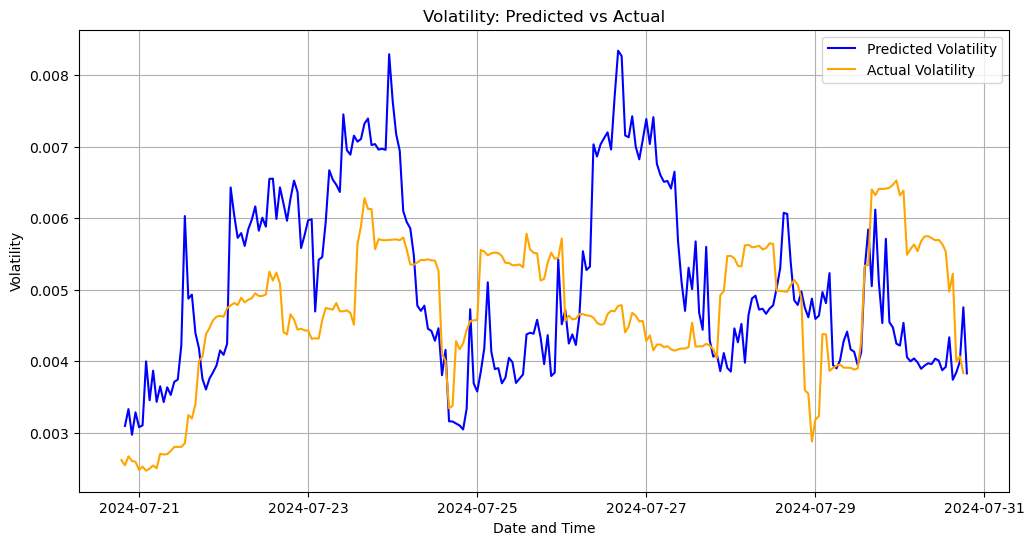

In [17]:
plt.figure(figsize=(12, 6))

# Adding the predicted values to the plot
plt.plot(future_df.index, future_df['predicted_volatility'], label='Predicted Volatility', color='blue')

# Adding the actual values to the plot
plt.plot(actual_prices.index, actual_prices, label='Actual Volatility', color='orange')

# Plot settings
plt.title('Volatility: Predicted vs Actual')
plt.xlabel('Date and Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

The model’s volatility predictions for the next 10-day period, highlighting its strengths and limitations. While the model successfully captures the general trend in volatility, noticeable discrepancies are observed, especially during periods of high volatility. These differences suggest that the model effectively tracks overall trends but may struggle to predict the exact magnitude of volatility spikes, which are crucial for anticipating liquidation cascades.

In conclusion, the HAR model shows strong potential for predicting volatility, a critical factor in managing risks associated with liquidation cascades. However, observed deviations in peak volatility predictions and the potential for overfitting suggest that further refinement is necessary. Improving the model’s accuracy during extreme market conditions and addressing overfitting risks are essential for enhancing its utility in real-world financial applications.
